# Using Python for Research: Final Project
## Introduction:
The goal of this project is to set up a statistical model which is able to predict the type of physical activity (e.g. walking, climbing stairs), based on data obtained from tri-axial smartphone accelerometers. 

The model developed here will classify any new input data into one of four categories: 1 = standing, 2 = walking, 3 = stairs down and 4 = stairs up. The input data will consist of the mutually perpendicular components of acceleration in space (x, y, z), which then our model will classify.

In order to train our model in the first place, we have already been provided with two files: 'train_time_series.csv' for the tri-axial data, and 'train_labels.csv' for the correctly labeled classes. Furthermore, we have also been provided with two additional files, 'test_time_series.csv' and 'test_labels.csv', where will store our predictions made by the model we have just trained.

The key steps that we performed in this project were:
1)  First and foremost, import the training data, inspect it and clean it.
2)  Next, set up variables and appropriate dataframes, to use as the covariates and outcomes.
3) After that, set up and use a logistic regression model and a random forest classifier, and compare their accuracies on the training data.
4) Pick the model with the higher accuracy, and use it to predict the labels of the test time series data.
5) Finally, store the predictions in the file named 'train_labels_complete.csv'.

## In the first section, we will import the training data, inspect it, and clean it.

This block will import the necessary modules for us.

In [ ]:
import time # we will the need the time module in order to measure the time elapsed in running the program
start_time = time.clock() # the clock is started on this line, before importing any other module or executing any other line of code.

import pandas as pd # the pandas module will enable me to view and manipulate data
import numpy as np  # the numpy module will enable me to carry out calculations quickly and efficiently.

import warnings     # this will supress a few unnecessary warnings; don't worry about it!
warnings.filterwarnings("ignore")

In the following block, we will import the training data and remove any rows which contain invalid data. The training data is finally stored as a pandas dataframe; you may have a look at its head below.

In [ ]:
# okay, so we begin here. First, we will import the training data (along with the labels), and eventually merge it into a single pandas dataframe called 'df_train'
df_train = pd.read_csv("train_time_series.csv", index_col=0)
df_labels = pd.read_csv("train_labels.csv", index_col=0)

df_train['label'] = df_labels['label']
df_train = df_train.replace([np.inf, -np.inf], np.nan) # this line (and the following one) will remove any rows of data containing 'NaN'
df_train = df_train.dropna(how="any")

# note: only those rows are considered for which a label was provided.
df_train.head()

,timestamp,UTC time,accuracy,x,y,z,label
20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1.0
20599,1565109932090,2019-08-06T16:45:32.090,unknown,0.013718,-0.852371,-0.000870,1.0
20609,1565109933092,2019-08-06T16:45:33.092,unknown,0.145584,-1.007843,-0.036819,1.0
20619,1565109934094,2019-08-06T16:45:34.094,unknown,-0.099380,-1.209686,0.304489,1.0
20629,1565109935097,2019-08-06T16:45:35.097,unknown,0.082794,-1.001434,-0.025375,1.0


In this block, we will set up the classification_target as 'label', because this is what we want to classify with our model. The covariates are also defined in the same block. Finally, we will also have a look at the skew of the covariates.

In [ ]:
classification_target = 'label' # I define my classification target here, namely 'label'.
continuous_covariates = ['x', 'y', 'z'] # the covariates which will be used to train the model (and later make predictions)

outcomes_and_continuous_covariates = continuous_covariates + [classification_target]
df_train[outcomes_and_continuous_covariates].skew() # these two lines will tell me how the data is currently skewed. Notice how the 'x' and 'z' data are right skewed? We will now correct this. (You don't have to worry about 'label'; that is merely our classification target)

x        0.294193
y       -1.111177
z        1.319239
label    0.601406
dtype: float64

As you can see, the 'x' and 'z' components of the acceleration have a right skew; in order to rectify this, I will apply a transformation to these variables. It is a good idea to take the logarithm of these components. However, the log function is not defined for non-positive inputs, so to make sure that we don't get NaNs all over, we will take the logarithm of the component plus a small number.

In [ ]:
for covariate in ['x', 'z']:
    df_train[covariate] = df_train[covariate].apply(lambda x: np.log10(2+x))

print(df_train[outcomes_and_continuous_covariates].skew()) # I have simple transformed the 'x' and 'z' columns so that now they are no longer right skewed.

x       -0.568802
y       -1.111177
z       -0.194454
label    0.601406
dtype: float64


## In this section, we will set up our models and train them.
Next, we will import a few modules from the 'scikit-learn' statistical models, as these are already available to us, and they are also designed to use shortcut methods which would be difficult for us to implement from scratch with our current skills (atleast that is what I believe!)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

# these modules are necessary in order to use the helpful 'scikit-learn' statistical models.
# matplotlib.pyplot will be used to draw any plots.

In the following block of code, we will set up the logistic regression and random forest classifier models, along with our defined classification target and the covariates.

Note: I have decided to use a random state of 0 for the random forest classifier to compare my results accross different runs.

In [ ]:
classification_target = 'label'
all_covariates = ['x', 'y', 'z']
classification_outcome = df_train[classification_target]
covariates = df_train[all_covariates] # these four lines of code define my classification outcomes and covariates, which are found in the df_train dataframe.

logistic_regression = LogisticRegression()
forest_classifier = RandomForestClassifier(max_depth=4, random_state=0) # I have simply instantiated the LogisticRegression and ForestClassifier (with a maximum depth of 4) models here. We will soon compare which one performs better on our training data.

I have defined an accuracy function over here, which will be used later on for cross-validation, in order to estimate how good our models will perform on unseen data (and to compare our two models against each other).

In [ ]:
# this function right here will compute the accuracy between the observed outcome y and the outcome predicted by the model.
def accuracy(estimator, X, y):
    predictions = estimator.fit(X, y).predict(X)
    return accuracy_score(y, predictions)

## Results:
You can see from the plot below that the random forest classifier performs much better than the linear classifier. Hence, we will go ahead and use the random forest classifier to make future predictions on unseen data.

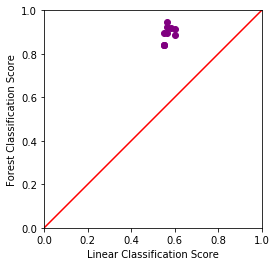

In [ ]:
# Determine the cross-validated accuracy for logistic and random forest models.
logistic_regression_scores = cross_val_score(logistic_regression, covariates, classification_outcome, cv=10, scoring=accuracy)
forest_classification_scores = cross_val_score(forest_classifier, covariates, classification_outcome, cv=10, scoring=accuracy)

# Plot Results
plt.axes().set_aspect('equal', 'box')
plt.scatter(logistic_regression_scores, forest_classification_scores, color='purple')
plt.plot((0, 1), (0, 1), 'k-', color='red')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Linear Classification Score")
plt.ylabel("Forest Classification Score")

plt.show()
# upon plotting these results, you will see that the forest classifier predicts better than the linear classifier (since all of the data points are above the line y = x, this means that the y-coordinates are all greater than the x-coordinates, i.e. the scores for the forest classifier are higher than the corresponding linear classifier scores.)

## The final section: we will now make predictions with our chosen model.
We're in the endgame now. In this block of code, we will import the test_time_series.csv data as a pandas dataframe, and perform a few necessary operations on it.

In [ ]:
df_test = pd.read_csv("test_time_series.csv", index_col=0) # now we will import the new test data as another pandas dataframe 'df_test,' and perform the standard cleanup rituals.
df_test = df_test.replace([np.inf, -np.inf], np.nan)
df_test = df_test.dropna(how="any")

print(df_test[continuous_covariates].skew())

for covariate in ['x', 'z']:
    df_test[covariate] = df_test[covariate].apply(lambda x: np.log10(2+x))

print(df_test[continuous_covariates].skew())
# I must transform the corresponding test data in exactly the same way, because I have used the transformed training data to train my models.

x    0.775765
y   -1.189414
z    1.162056
dtype: float64
x   -0.419302
y   -1.189414
z   -0.685104
dtype: float64


And now, for the final predictions...

In [ ]:
# finally, I will save my predictions in a new columns called 'label'
df_test['label'] = forest_classifier.fit(covariates, classification_outcome).predict(df_test[all_covariates])

We cannot test our predictions yet with the given input files. However, we can save our predictions in another file for future reference. We will import the 'test_labels.csv' file, store the labels for the corresponding rows and save it finally as 'test_labels_complete.csv'

In [ ]:
# and then save the 'test_labels.csv' file as a new file 'test_labels_complete.csv', with the labels column filled in.
df_test_labels = pd.read_csv("test_labels.csv", index_col=0)
df_test_labels['label'] = df_test['label']

df_test_labels.to_csv("test_labels_complete.csv", encoding='utf-8') # note: if you want to read in this csv file in python, make sure to use the encoding parameter exactly as on this line.
end_time = time.clock()
print(end_time - start_time) # this line will give you the program runtime in seconds.

3.5026207


As it so happens, the runtime for the code is around 3.50 seconds.

## Results:
Finally, upon testing the accuracy of the predicted labels on the edX website, I obtained a score of around 41.6%.

## Conclusion:
This is an unusually low score, and it may be the result of an error in my work; perhaps the method I have implemented is overfitting the training data somehow (because as we can see from the plot, atleast the model performs well on the training data).